# Hopfield Network With Hashing - Hopfield

This is a memory mechanism in a form of a Hopfield network. The stored items are called memory patterns. They are retrieved by a process of the input that is presented to the network dynamics which at some time step reaches a fixed stable point. This means that the input item has been recognized (i.e. there is a memory pattern identical or very similar to it).

Even noisy sounds or those corrupted to some extent can be accessed. In other words, if the input is $x_1 + \delta$ and the stored item is $x_1$, the network will still reach the fixed point of $x_1$ if $\delta$ is small enough.

Additionally, for storage purposes, sounds are transformed each into a hash - with this we reduce their dimensionality. This means we increase the storage capacity. 

# Build the system

### Load dependencies

In [1]:
# First, we load the neccessary dependencies.

import numpy as np
import math
import librosa
import scipy.io.wavfile as wav
import sys
import glob
import pickle
import random
import seaborn
import pandas as pd

%matplotlib inline

In [2]:
# Folder with some wav files to test this script.

folder_train = "./wavs/"

test_folder = "./test_wavs/"

### Extract Features

First, we will transform our .wav files into features, in this case MFCCs.

In [3]:
def make_mfcc(folder):
    """
    Go through the folder and find all (and only) files ending with .wav
    Here, we transform each .wav file into MFCCs and then flatten them into one vector.
    We do this because we want one hash per .wav file.
    
    Any file shorter than the longest file in the folder will be padded with values 0,
    so that all concatenated file vectors are of the same length.
    
    Parameters
    ----------
    folder : path to folder with wav sounds
    
    Returns
    -------
    a list of flattened MFCC vectors
    """
    vectors = []
    for file in glob.glob(folder + "*.wav", recursive=True):
        y, sr = librosa.load(file)
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
        print(len(vectors), " mfccs done")
    # find the largest vector
    max_length = len(max(vectors, key=lambda p: len(p)))
    # append zeros to all the other vectors
    for i in range(len(vectors)):
        vectors[i] = np.pad(vectors[i], (0,max_length-len(vectors[i])))
    return vectors

### Hashing of features

Now we will use these features and transform them into hash vectors, which we will use to store in our memory. We do this to facilitate memory storage: hashes are vectors with reduced dimensionality, with values mostly equal to 0 and a few of them equal to 1.

In [4]:
def hash_dim(d,k,m,seed):  
    
    """
    Define hash parameters.
    The hash will be a matrix of the dimension = k*m
    We choose a random number k of units of the vector.
    
    Parameters
    ----------
    d : num
        Length of a random vector being stored
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will  do the hashing for some vector
    seed : num
        We always want the same units randomly chosen
        
    Returns
    -------
    a numpy array 
        p of dimensions [k,m] represents randomly chosen dimensions
    
    """   
    assert k <= d
    p = np.zeros((m,k,))
    np.random.seed(seed)
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
    return p

    
def get_hash(vector, k, m, p): 
    """
    Transform a vector of speech into a hash
    The hash will be a matrix of the dimension = k*m
    
    Once we have chosen k random dimensions, we look for the highest 
    value and turn it into 1. Everything else is 0.
    We thus get sparse matrices.
    We do this m times. Final output is h=k*m.
    
    Parameters
    ----------
    vector : np.array
        Features (i.e. MFCC) of some sound with dim = 1*n
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    p : numpy array
        p of dimensions [k,m] represents randomly chosen dimensions
        
    Returns
    -------
    a numpy array h of size [1, k*m]
    """
    h = np.zeros((m,k,))
    for i in range(m):
        p_line = p[i].astype(int)
        ix = np.argmax(vector[p_line])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h

In [5]:
# TEST

expected_h = np.array([[1,0,0],[0,0,1]]).flatten()
vector = np.array([6,4,5,9,2])
# %timeit hash_dim(len(vector),3,2,2).astype(int)
p0 = hash_dim(len(vector),3,2,2).astype(int)
print("This is a test hash: ", get_hash(vector, 3, 2, p0))
assert get_hash(vector, 3, 2, p0).all() == expected_h.all()

This is a test hash:  [1. 0. 0. 0. 0. 1.]


### Memory storage

We must now construct our neuron weight matrix that reopresents the connections between neurons of our memory network.
We will first initialize our matrix representing the synaptic weights and then enable subsequent addition of new memories.

Synaptic weight matrix is a matrix that represents connections between each and every neuron. Every neuron has a state which can be active or inactive. Initialization of synaptic weights will make the connection between two neurons such that it is strengthened if both neurons are active (and the other way round, it will weaken the connection if one of the neurons is inactive).

In [6]:
def initialize_network(N, p, V=None):
    """
    Eq. (2) from [1]
    
    Initialize synaptic weights in form of matrix T (symmetric recurrent weight matrix).
    This is a memory storage.
    
    Parameters
    ----------
    N : num
        number of neurons
    V : list
        list of vectors in a hash form
    p : num
        sparsity - probability of a value being 1
    Returns
    -------
    a numpy array T of shape (N, N)
        Memory storage in form of a matrix (synaptic weights)
        Its dimensions are determined by N=k*m (hash parameters)
    """
    
    T = np.zeros((N,N))
    if not(V is None):
        for vect in V:
            T = add_memory(T, vect, p)  
    return T


def add_memory(T, new_memory, p):
    """
    Eq. (2) from [1]
    
    Update synaptic weights in form of matrix T (symmetric recurrent weight matrix) when adding new memory.
    
    Parameters
    ----------
    T : a numpy array T_sum of shape (N, N)
        Initialized memory storage in form of a matrix (synaptic weights)
    new_memory : numpy array of shape (1,N)
        a vector we wish to store
    p : num
        a number representing the probability of a value being 1 (i.e. sparsity)
        
    Returns
    -------
    a numpy array T of shape (N, N)
        Renewed memory storage in form of a matrix (synaptic weights)
        Its dimensions are determined by N=k*m (hash parameters)
    """
    N = np.shape(T)[0]
#     if method == "default":
#         v = 2*new_memory - 1 #hopfield

    v = new_memory - p #tsodyks
#     elif method == "amits":
#         v = 2*new_memory - 2*p #amits
    outer_prod = np.outer(v,v)
    np.fill_diagonal(outer_prod, 0)
    T += outer_prod
        
    return T

### Memory retrieval

When we want to retrieve a memory, we start with some initial state and then observe the dynamics of the system - if it reaches a stable point, we have accessed to either some stored memory or to a state by default where we can end up if we have not stored something similar to initial state.

In other words, we can represent this as a surface with differently sized bumps. We put a ball on this surface and it will roll into the nearest pit, unless we already put it on the already lowest point of the pit.

To check whether this lowest point (or stable/fixed point) was reached, we check stability of being there - have we been here a few moments ago? 

In [7]:
# Not up to date
def energy(T, V, g=1, p=0.5, adapted=False):
    """
    Eq. (7) from [1]
    
    Energy of the system is a monotonically decreasing function.
    
    Parameters
    ----------
    T : a numpy array of shape (N, N)
        Memory in form of a matrix (synaptic weights)
    V : numpy array
        a list of states of activation
        
    Returns
    -------
    num
        Energy of the system
    """
    E = 0
    N = np.shape(T)[0] # num of neurons
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            if adapted==True:
                M = sum(V[i])
                a = 2*p-1
                E -= 1/2 * (T[i,j] * V[i] * V[j]) - (g/(2*N))*(M-N*a)^2
            else:
                E -= 1/2 * (T[i,j] * V[i] * V[j])
    return E

In [18]:
def retrieve_memory(T, V0, U=0, downstate=0, full_trace=True, SEED=27, check_frequency=1):
    """
    Eq. (1) from [1]
    
    To retrieve a memory, we want to find the stable/fixed point of the 
    dynamic network represented by matrix T (synaptic weights in which
    the memory is stored) when starting from vector V.

    Parameters
    ----------
    T : a numpy array T of shape (N, N)
        Memory in form of a matrix (synaptic weights)
    V0 : a numpy array of shape (1, N)
        a vector with which we initialize the network activity (check if it is stored in T)
    g : num
        parameter
    U : num
        a scalar representing the threshold of neuron's state of activity.
        Set to 0 by default.
        "With a threshold of 0, the system behaves as a forced categorizer." [1]
    full_trace : boolean
        Set to True by default. This means we will keep all the changes of the initial neuron states
        as they change through time.
    SEED : num
        Used for the random choices of indices, which we can control for replication by always 
        setting the seed to the same number.
        
    Returns
    -------
    a numpy array of shape (1, N)
        We return the new / denoised V
    """
    random.seed(SEED)
    conv_check_spacing = len(V0)*check_frequency 
    
    V = V0.copy()
    if full_trace:
        V_history = [V.copy()]
    j = 0
    while not has_converged(T, U, V, downstate):
#         j += 1
#         if np.mod(j, 10) == 0:
#             print(V)
        for _ in range(conv_check_spacing):
            i = random.randrange(V.shape[0])
            V[i] = update_neuron(T, U, V, i, downstate)
            if full_trace:
                V_history.append(V.copy())

    if full_trace:
        return V_history
    else:
        return V


def update_neuron(T, U, V, i, downstate=0):
    """
    We calculate sum_j {T_ji * V[j]}, where T_ij is our synaptic weight between neuron j and i
    and V[j] is a j-th neuron state 
    
    Parameters
    ----------
    T : a numpy array T_sum of shape (N, N)
        Initialized memory storage in form of a matrix (synaptic weights)
    V : num
        a scalar representing the neural network state
        
    Returns
    -------
    num
        We return the sum of all components of i-th column of T, each multiplied by V_j
    """
    membrane_potential = sum(T[:,i] * V)
    new_V_i = check_threshold(membrane_potential, U, downstate)
    return new_V_i



def check_threshold(membrane_potential, U, downstate):
    """
    Check whether the sum of T_ij * V_j is bigger or smaller than the threshold U

    Parameters
    ----------
    membrane_potential : num
        Sum over T_ij * V_j
    U : num
        a scalar representing a threshold of neuron's state of activity
        
    Returns
    -------
    num
        We return either 0 or 1, depending on TV_sum being smaller
        or larger than the threshold U
    """
    if membrane_potential > U:
        return 1
    else:
        return 0
    
    
def has_converged(T, U, V, downstate):
    """
    Check whether the new V_i is the same as i-th value of V
    and whether the current energy is equal to the previous one

    Parameters
    ----------
    V_i : num
        state of V's i-th neuron (either active: 1, or inactive: 0)
    V : num
        a numpy array representing all current neurons' states of activity
    i : num
        current randomly chosen index
    E_list : list
        list of all energy values so far
        
    Returns
    -------
    boolean
        We return False if we satisfy at least one of the conditions,
        else we return True
    """
    converged = True
    for i, V_i in enumerate(V):
        updated_V_i = update_neuron(T, U, V, i, downstate)
        if updated_V_i != V_i:
            converged = False
            break
    return converged 

In [19]:
# TEST

toy_V1 = np.array([0,1])
toy_V2 = np.array([1,0])
# %timeit initialize_network(2, [toy_V1, toy_V2])
toy_T = initialize_network(2, 0.1, [toy_V1, toy_V2])
print("Toy T matrix: \n", toy_T)
print("Retrieved memory of [0,0] - unstored:\n", retrieve_memory(toy_T, np.array([0,0])))
print("Retrieved memory of [1,1] - unstored:\n", retrieve_memory(toy_T, np.array([1,1])))
print("Retrieved memory of [9,9] - unstored:\n", retrieve_memory(toy_T, np.array([9,9])))
print("Retrieved memory of [0,1] - stored:\n", retrieve_memory(toy_T, toy_V1))

Toy T matrix: 
 [[ 0.   -0.18]
 [-0.18  0.  ]]
Retrieved memory of [0,0] - unstored:
 [array([0, 0])]
Retrieved memory of [1,1] - unstored:
 [array([1, 1]), array([1, 0]), array([1, 0]), array([1, 0]), array([0, 0])]
Retrieved memory of [9,9] - unstored:
 [array([9, 9]), array([9, 0]), array([9, 0]), array([9, 0]), array([0, 0])]
Retrieved memory of [0,1] - stored:
 [array([0, 1]), array([0, 0]), array([0, 0])]


# TESTS

We can now inspect our memory network and test it:

## Load or make speech vectors

In [25]:
# REAL VECTORS, ALL FILES - SAVE

# Uncomment to make MFCCs

# mfccs_vectors = make_mfcc(folder_train)
# # store the mfccs as a pickle file 
# with open("vectors.txt", "wb") as fp:
#      pickle.dump(mfccs_vectors, fp)

In [ ]:
# TEST VECTORS, ONLY 4 FILES - SAVE

# mfccs_vectors = make_mfcc(test_folder)
# # store the mfccs as a pickle file 
# with open("test_vectors.txt", "wb") as fp:
#      pickle.dump(mfccs_vectors, fp)

In [10]:
# LOAD ALL MFCCS

with open("vectors.txt", "rb") as fp:
     mfccs_vectors = pickle.load(fp)

# length of an utterance vector
len(mfccs_vectors[1])

12980

## Test: PRECISION RECALL

In [11]:
def hash_dataset(mfccs_vectors, k, m, SEED):
    """
    Make a hashed dataset with parameters k and m and with the extracted mfccs.

    Parameters
    ----------
    mfccs_vectors : numpy array
        array of mfcc vector arrays extracted from an audio file, each array is a file
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    Returns
    -------
    list
        We return a list of numpy arrays, each representing a hashed audio file
    """
    d = len(mfccs_vectors[0])
    V =[]
    p = hash_dim(d,k,m,SEED).astype(int)
    for vect in mfccs_vectors:
        v = get_hash(vect, k, m, p)
        V.append(v) 
    return V

In [47]:
def precision_recall(T, V_train, V_test, N, U, DOWNSTATE):
    """
    Perform a precision recall test on chosen files and parameters.

    Parameters
    ----------
    T : a numpy array T of shape (N, N)
        Memory in form of a matrix (synaptic weights)
    V_train : list of arrays (hashed features)
        The data we train our memory system on
    V_test : list of arrays (hashed features)
        The data we tast the memory system on
    N : num
        N=k*m, where k is the number of zeros in the hashed vector, m is number of ones
    U : num
        Chosen threshold above which the neuron is active
    Returns
    -------
    num
        We return values of hits, false alarms, correct rejections, misses
    """
    
    correct_rejection = 0
    false_alarm = 0
    default = np.zeros(N)
    for v in V_test:
        memory = retrieve_memory(T, v, U=U, downstate=DOWNSTATE, full_trace=False)
        if np.array_equal(memory, default):
            correct_rejection += 1
        else:
            false_alarm += 1
    correct_rejection = correct_rejection/len(V_test)
    false_alarm = false_alarm/len(V_test)

    hits = 0
    miss = 0
    default = np.zeros(N)
    for v in V_train:
        memory = retrieve_memory(T, v, U=U, downstate=DOWNSTATE, full_trace=False)
        if np.array_equal(memory, default):
            miss += 1
        else:
            hits += 1
    hits = hits/len(V_train)
    miss = miss/len(V_train)
    
    
    return hits, false_alarm, correct_rejection, miss

In [44]:
def range_for_N(k, minimum, maximum, num_points):
    """
    Finds equally spaced values for N, from pre-defined minimum to 
    pre-defined maximum. N is the dimension of our memory storage 
    (which is of the size N*N).

    Parameters
    ----------
    k : num
        Number of units we randomly choose of the vector
    minimum : num
        Minimum number we want the range to start from
    maximum : num
        Maximum number we want the range to stop at
    num_points : nuim
        The number of points we want between and including min and max
    
    Returns
    -------
    list
        We return a list of the number num_points from min to max
    """
    
    minimum_ = np.ceil(minimum/k)
    maximum_ = np.floor(maximum/k)
    range_N = np.unique(np.round(np.linspace(minimum_, maximum_, num_points)).astype(int))
    return k*range_N

In [84]:
from fractions import Fraction
S = [Fraction(1,x) for x in range(2,100)]
S = [Fraction(1,100), Fraction(10,100), Fraction(50,100)]
data = {"sparsity":[], "threshold":[], "N":[], "TPR":[], "FPR":[]}
SEED = 27
minimum_N = 100
maximum_N = 200
num_points_N = 2

METHOD = "amits"
DOWNSTATE = 0

# for threshold in np.linspace(-1,5,25):
for threshold in [5]:
    for s in S:
        p = float(s)
        k = int(1/s)
        assert k == 1/s
        N_list = range_for_N(k, minimum_N, maximum_N, num_points_N)
        for N in N_list:
            m = int(N/k)
            assert m == N/k, (m,N/k)
            print("k, m: ", k, m)
            U = threshold
            g = 100

            V = hash_dataset(mfccs_vectors, k, m, SEED)
#             V_train = V[:len(V)//2]
#             V_test = V[len(V)//2:]
            V_train = V[:15]
            V_test = V[:30]
            if METHOD == "default":
                T_I = initialize_network(N, 0.5, V_train) # no inhibition
                U_eff = U
            elif METHOD == "amits":
                T = initialize_network(N, p, V_train)            
    #             a=2*p-1
                T_I = T-g/N # with inhibition
                np.fill_diagonal(T_I, 0)
                U_eff = U+g*(.5/N-p)
            elif METHOD == "tsodyks":
                T_I = initialize_network(N, p, V_train)  # no inhibition          
                U_eff = U+N*p
            elif METHOD == "both":
                T = initialize_network(N, p, V_train)
                T_I = T-g/N # with inhibition
                U_eff = U+N*p+g*(.5/N-p)
            data["threshold"].append(U_eff)
            data["N"].append(N)
            hit, fa, corr_rej, miss = precision_recall(T_I, V_train, V_test, N, U_eff, DOWNSTATE)
            if hit + miss == 0:
                TPR = np.NaN
            else:
                TPR = hit / (hit + miss)
            if fa + corr_rej == 0:
                FPR = np.NaN
            else:
                FPR = fa / (fa + corr_rej)
            data["TPR"].append(TPR)
            data["FPR"].append(FPR)
            data["sparsity"].append(p)

data = pd.DataFrame(data)

k, m:  100 1
k, m:  100 2
k, m:  10 10
k, m:  10 20
k, m:  2 50
k, m:  2 100


In [85]:
# Write the data into a .csv file
data.to_csv("./results/precision_recall/TPR_FPR_" + METHOD + ".csv")

data

,sparsity,threshold,N,TPR,FPR
0,0.01,4.50,100,0.0,0.0
1,0.01,4.25,200,0.0,0.0
2,0.10,-4.50,100,1.0,1.0
3,0.10,-4.75,200,1.0,1.0
4,0.50,-44.50,100,1.0,1.0
5,0.50,-44.75,200,1.0,1.0


### Precision recall with artificial stimuli

In [199]:
def test_PR_artificial(p, METHOD, N = 100, n_list = [5, 10, 15], threshold = 10, SEED = 27):
    g = 100
    U = threshold
    V = []
    DOWNSTATE = 0
    data = {"threshold":[], "N":[], "n":[], "TPR":[], "FPR":[], "p":[]}
    
    for n in range(1,100):
        rndm_vect = np.random.binomial(1, p, size=N)
        V.append(rndm_vect) 

    for n in n_list:
        V_train_test = V[:n]
        if METHOD == "default":
            T_I = initialize_network(N, 0.5, V_train_test) # no inhibition
            U_eff = U
        elif METHOD == "amits":
            T = initialize_network(N, p, V_train_test)            
#             a=2*p-1
            T_I = T-g/N # with inhibition
            np.fill_diagonal(T_I, 0)
            U_eff = U+g*(.5/N-p)
        elif METHOD == "tsodyks":
            T_I = initialize_network(N, p, V_train_test)  # no inhibition          
            U_eff = U+N*p
        elif METHOD == "both":
                T = initialize_network(N, p, V_train)
                T_I = T-g/N # with inhibition
                U_eff = U+N*p+g*(.5/N-p)
            
        # Test the system with the same vectors that are stored in memory
        # Check how many values of each state has changed
        data["threshold"].append(U_eff)
        data["N"].append(N)
        data["n"].append(n)
        hit, fa, corr_rej, miss = precision_recall(T_I, V_train_test, V_train_test, N, U_eff, DOWNSTATE)
        if hit + miss == 0:
            TPR = np.NaN
        else:
            TPR = hit / (hit + miss)
        if fa + corr_rej == 0:
            FPR = np.NaN
        else:
            FPR = fa / (fa + corr_rej)
        data["TPR"].append(TPR)
        data["FPR"].append(FPR)
        data["p"].append(p)

        
    results = pd.DataFrame(data)   
    return(results)


mtd = "tsodyks"
results05_PR = test_PR_artificial(p=0.5,METHOD = mtd)
results01_PR = test_PR_artificial(p=0.1,METHOD = mtd)
results001_PR = test_PR_artificial(p=0.01,METHOD = mtd)

results = results05_PR.append(results01_PR)
results = results.append(results001_PR)

results

,threshold,N,n,TPR,FPR,p
0,60.0,100,5,0.0,0.0,0.50
1,60.0,100,10,0.0,0.0,0.50
2,60.0,100,15,0.0,0.0,0.50
0,20.0,100,5,0.0,0.0,0.10
1,20.0,100,10,0.0,0.0,0.10
2,20.0,100,15,0.0,0.0,0.10
0,11.0,100,5,0.0,0.0,0.01
1,11.0,100,10,0.0,0.0,0.01
2,11.0,100,15,0.0,0.0,0.01


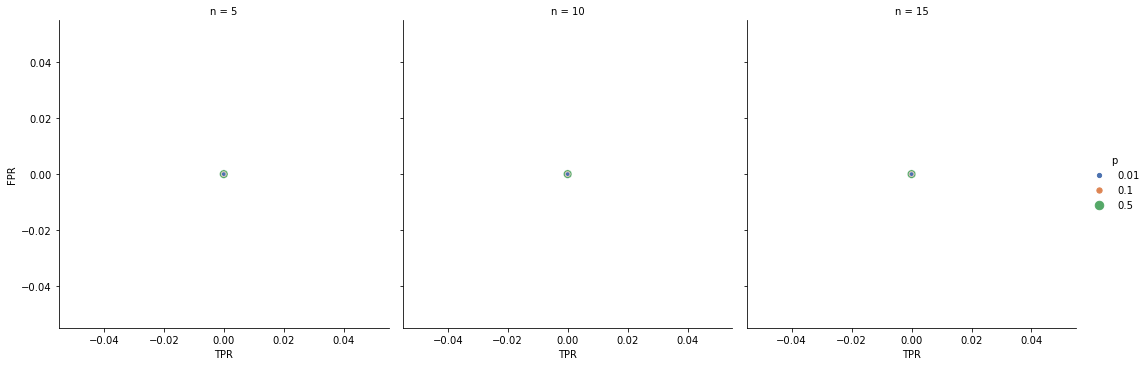

In [200]:
scatter_pr = sns.relplot(data=results, x="TPR", y="FPR", size="p", hue = "p", palette = "deep", col="n")

plt.show(scatter_pr)

scatter_pr.savefig('./results/precision_recall/artificial_N100_'+mtd+'.png')

### Count errors using real data (hashed vectors)

In [171]:
from fractions import Fraction
S = [Fraction(1,x) for x in range(2,100)]
S = [Fraction(1,100), Fraction(10,100), Fraction(50,100)]
SEED = 27
num_points_N = 2
results = {"threshold":[], "N":[], "n":[], "errors":[], "p":[]}
METHOD = "tsodyks"
DOWNSTATE = 0
N = 100

# for threshold in np.linspace(-1,5,25):
for threshold in [0]:
    for s in S:
        p = float(s)
        k = int(1/s)
        assert k == 1/s

        m = int(N/k)
        assert m == N/k, (m,N/k)
        
        print("k, m: ", k, m)
        U = threshold
        g = 100

        V = hash_dataset(mfccs_vectors, k, m, SEED)
#             V_train = V[:len(V)//2]
#             V_test = V[len(V)//2:]
        for n in [5, 10, 15]:
            V_train_test = V[:n]
            if METHOD == "default":
                T_I = initialize_network(N, 0.5, V_train_test) # no inhibition
                U_eff = U
            elif METHOD == "amits":
                T = initialize_network(N, p, V_train_test)            
    #             a=2*p-1
                T_I = T-g/N # with inhibition
                np.fill_diagonal(T_I, 0)
                U_eff = U+g*(.5/N-p)
            elif METHOD == "tsodyks":
                T_I = initialize_network(N, p, V_train_test)  # no inhibition          
                U_eff = U+N*p
            elif METHOD == "both":
                T = initialize_network(N, p, V_train_test)
                T_I = T-g/N # with inhibition
                U_eff = U+N*p+g*(.5/N-p)


            for (i, memory_state) in enumerate(V_train_test):
    #             print(i)
                retrieved_state = retrieve_memory(T_I, memory_state, U=U_eff, downstate=DOWNSTATE, full_trace=False)
                counts = count_errors(memory_state, retrieved_state)
                results["threshold"].append(U_eff)
                results["N"].append(N)
                results["n"].append(n)
                results["errors"].append(counts)    
                results["p"].append(p)
#             results = results.append(data)
        
        


results = pd.DataFrame(results)


k, m:  100 1
k, m:  10 10
k, m:  2 50


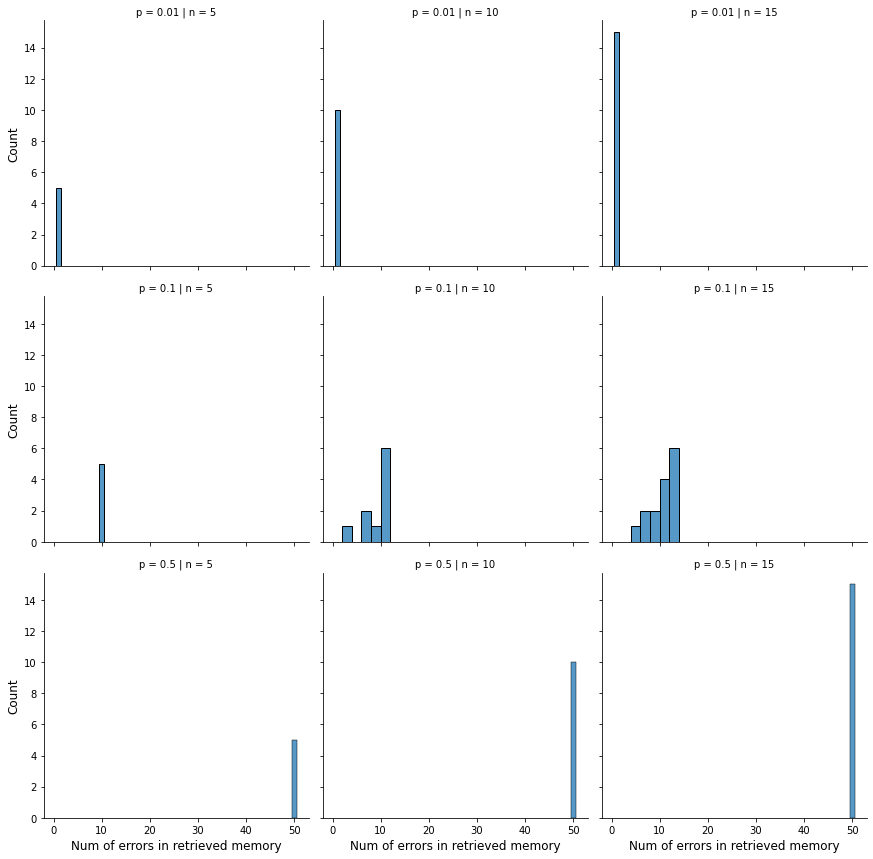

In [172]:
f = sns.FacetGrid(results, row = "p", col="n", height=4, aspect=1)
f.map(sns.histplot, "errors")
f.set_axis_labels('Num of errors in retrieved memory', 'Count', size = 12)

plt.show(f)
f.savefig('./results/num_errors/hash_N100_'+METHOD+'.png')

In [48]:
# Read the .csv with data
# data=pd.read_csv("./results/precision_recall/TPR_FPR_" + METHOD + ".csv", index_col=0)
# data

In [49]:
# data = data[data['TPR'].notna()]
# data = data[data['FPR'].notna()]
# f = seaborn.relplot(x="FPR", y = "TPR", data = data, col = "threshold", row = "N")
# # plt.savefig('tpr_fpr.png')
# for ax in f.axes.flatten():
#     ax.grid()

# f.savefig('./results/precision_recall/tpr_fpr_filtered_' + METHOD + '.png')

## Test: COUNT ERRORS
Generate random vectors to replicate the simulation results that Hopfield obtained with this implementation: errors in retrieved pattern reach 50% when the number of stored patterns exceeds 15 percent of the number of neurons for a given number of neurons.

In [99]:
def count_errors(initial_state, retrieved_state):
    equality_values = initial_state == retrieved_state
    count = np.count_nonzero(equality_values)
    return(len(equality_values)-count)


def test_sparsity(p, METHOD, N = 100, n_list = [5, 10, 15], threshold = 0, SEED = 27):
    g = 100
    U = 0
    V = []
    DOWNSTATE = 0
    results = {"threshold":[], "N":[], "n":[], "errors":[]}
    for n in range(1,100):
        rndm_vect = np.random.binomial(1, p, size=N)
        V.append(rndm_vect) 

    for n in n_list:
        V_train_test = V[:n]
        if METHOD == "default":
            T_I = initialize_network(N, 0.5, V_train_test) # no inhibition
            U_eff = U
        elif METHOD == "amits":
            T = initialize_network(N, p, V_train_test)            
#             a=2*p-1
            T_I = T-g/N # with inhibition
            np.fill_diagonal(T_I, 0)
            U_eff = U+g*(.5/N-p)
        elif METHOD == "tsodyks":
            T_I = initialize_network(N, p, V_train_test)  # no inhibition          
            U_eff = U+N*p
        elif METHOD == "both":
                T = initialize_network(N, p, V_train)
                T_I = T-g/N # with inhibition
                U_eff = U+N*p+g*(.5/N-p)
            
        # Test the system with the same vectors that are stored in memory
        # Check how many values of each state has changed
        for (i, memory_state) in enumerate(V_train_test):
#             print(i)
            retrieved_state = retrieve_memory(T_I, memory_state, U=U_eff, downstate=DOWNSTATE, full_trace=False)
            counts = count_errors(memory_state, retrieved_state)
            results["threshold"].append(U_eff)
            results["N"].append(N)
            results["n"].append(n)
            results["errors"].append(counts)
        
    results = pd.DataFrame(results)   
    return(results)

def plot_errors(DATA, P):
    f = sns.FacetGrid(DATA, col="n", height=4, aspect=1)
    f.map(sns.histplot, "errors")
    f.set_axis_labels('Num of errors in retrieved memory', 'Count', size = 12)
    bbox = f.axes[0,0].get_position()
    centerx=0.5*(bbox.x0+bbox.x1) 
    centery=1*(bbox.y0+bbox.y1) 
    TITLE = "N=100, p= %.2f, n=[5,10,15]" %P
    plt.suptitle(TITLE, y=centery, size= 18)
    return(f)

In [100]:
mtd = "amits"
results05 = test_sparsity(p=0.5,METHOD = mtd)
results01 = test_sparsity(p=0.1,METHOD = mtd)
results001 = test_sparsity(p=0.01,METHOD = mtd)

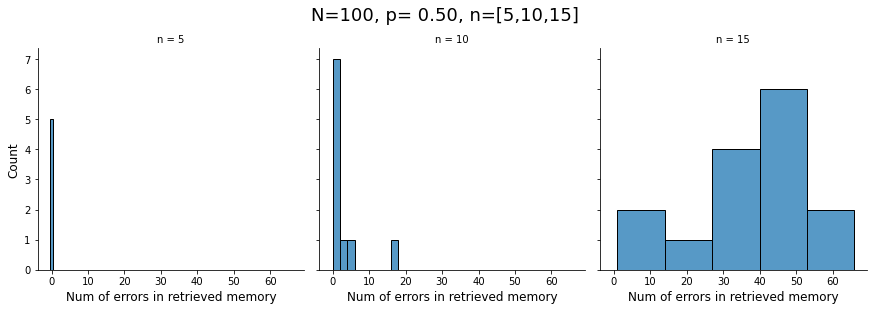

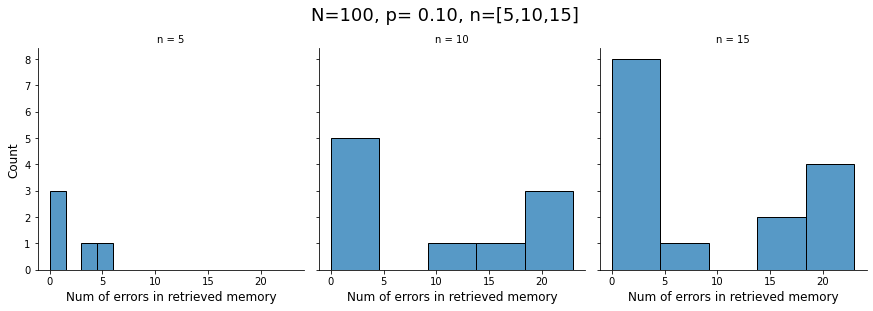

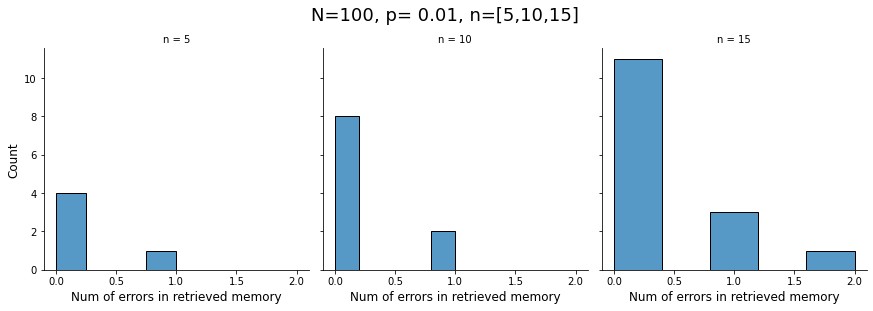

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt_05 = plot_errors(results05, 0.5)
plt.show(plt_05)
plt_05.savefig('./results/num_errors/N100_05_'+mtd+'.png')


plt_01 = plot_errors(results01, 0.1)
plt.show(plt_01)
plt_01.savefig('./results/num_errors/N100_01_'+mtd+'.png')


plt_001 = plot_errors(results001, 0.01)
plt.show(plt_001)
plt_001.savefig('./results/num_errors/N100_001_'+mtd+'.png')

## TESTING PROPERTIES OF THE CODE (to be deleted later)

In [ ]:
# TIMING TEST

SEED = 29
k=5
m=3
V = hash_dataset(mfccs_vectors, k, m, SEED)
V_train = V[:len(V)//2]
V_test = V[len(V)//2:]
T = initialize_network(k*m, V_train)
threshold=0

%prun range_for_N(k, 500, 1000, 20)

In [ ]:
# TEST FOR SYNAPTIC WEIGHT MATRIX (NEGATIVE VALUES)

k, m = 2,5
SEED = 27
V = hash_dataset(mfccs_vectors, k, m, SEED)
V1 = V[1]
V2 = V[2]
V1, V2
T = np.outer(2*V1-1, 2*V1-1) + np.outer(2*V2-1, 2*V2-1)
np.fill_diagonal(T, 0)
print("T", T)

V10 = V1.copy()
for i in range(10):
    s = sum(T[i]*V1)
    V[i] = update_neuron(T, 110, V1, i)
    print(i, V10[i], V1[i], s)

for i in range(10):
    s = sum(T[i]*V2)
    V[i] = update_neuron(T, 110, V1, i)
    print(i, V10[i], V1[i], s)

### References

[1] Hopfield, J. J. (1982). Neural networks and physical systems with emergent collective computational abilities. Proceedings of the national academy of sciences, 79(8), 2554-2558. 
[https://doi.org/10.1073/pnas.79.8.2554]

[2] Andoni, A., & Indyk, P. (2006, October). Near-optimal hashing algorithms for approximate nearest neighbor in high dimensions. In 2006 47th annual IEEE symposium on foundations of computer science (FOCS'06) (pp. 459-468). IEEE.
[https://10.1109/FOCS.2006.49]

In [ ]:
# check count errors with mfccs
# 1 memory, others fake should go to 0
# 